In [109]:
%matplotlib inline

import numpy as np
from scipy.stats import norm, truncnorm
import matplotlib.pyplot as plt
import math
import torch

print('Import done.')

Import done.


Manually compute normal pdf and cdf.

In [110]:
def norm_pdf_manual(e):
    return np.exp(-0.5 * e**2) / np.sqrt(2*math.pi)

def norm_cdf_manual(e):
    return 0.5 * (1+math.erf(e/np.sqrt(2)))


Compare with torch implementation.

In [111]:
x = torch.tensor(2, dtype=torch.float, requires_grad=True)
loss = torch.special.erf(x)
loss.backward()
print(x.grad)


m = torch.distributions.normal.Normal(torch.tensor([0.0]), torch.tensor([1.0]))
y = torch.tensor(1, dtype=torch.float, requires_grad=True)
print(torch.exp(m.log_prob(y)))
print(norm_pdf_manual(1))
print(m.cdf(y))
print(norm_cdf_manual(1))

tensor(0.0207)
tensor([0.2420], grad_fn=<ExpBackward0>)
0.24197072451914337
tensor([0.8413], grad_fn=<MulBackward0>)
0.8413447460685429


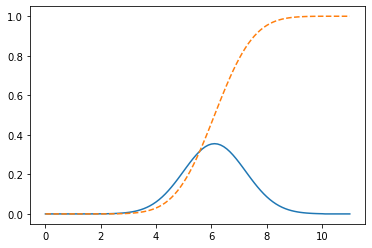

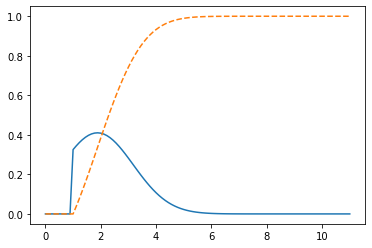

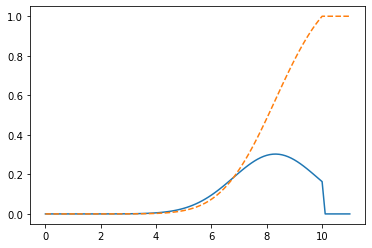

In [112]:
INV_SQRT_TWO = 1 / math.sqrt(2)
INV_SQRT_TWOPI = 1 / math.sqrt(2*math.pi)

def big_phi(x):
    return 0.5 * (1 + (x * INV_SQRT_TWO).erf())

def trunc_pdf(x, mu, sigma, a, b):
    def normalize(val):
        return (val-mu)/sigma
    phi_x = INV_SQRT_TWOPI * ((-0.5*(normalize(x)**2)).exp())
    big_phi_a = big_phi(normalize(torch.tensor(a)))
    big_phi_b = big_phi(normalize(torch.tensor(b)))
    pdf = phi_x / (big_phi_b-big_phi_a) / sigma
    return (pdf * (x>=a) * (x<=b)).clamp(0, 1)

def trunc_cdf(x, mu, sigma, a=1, b=10):
    def normalize(val):
        return (val-mu)/sigma
    big_phi_x = big_phi(normalize(x))
    big_phi_a = big_phi(normalize(torch.tensor(a)))
    big_phi_b = big_phi(normalize(torch.tensor(b)))
    cdf = (big_phi_x-big_phi_a) / (big_phi_b-big_phi_a)
    return cdf.clamp(0, 1) * (x>=a)

def test_plot(mu, sigma):
    y = torch.tensor(np.linspace(0, 11, 100))
    pdf_y = trunc_pdf(y, mu, sigma, 1, 10)
    cdf_y = trunc_cdf(y, mu, sigma, 1, 10)
    plt.plot(np.linspace(0, 11, 100), pdf_y)
    plt.plot(np.linspace(0, 11, 100), cdf_y, '--')
    plt.show()

test_plot(6.112903225806452, 1.1231413134550763)
test_plot(1.8805194805194805, 1.2929206807150266)
test_plot(8.31081081081081, 1.5202387893775977)

In [113]:
def trunc_cdf_ava(x, mu, sigma, a=0.5, b=10.5):
    def normalize(val):
        return (val-mu)/sigma
    big_phi_x = big_phi(normalize(x))
    big_phi_a = big_phi(normalize(torch.tensor(a)))
    big_phi_b = big_phi(normalize(torch.tensor(b)))
    cdf = (big_phi_x-big_phi_a) / (big_phi_b-big_phi_a)
    return cdf

def cjs_loss(y_true, y_pred):
    loss = 0
    y1s = [trunc_cdf_ava(i+1.5, y_true[:,0], y_true[:,1])*1000+1 for i in range(10)]
    y2s = [trunc_cdf_ava(i+1.5, y_pred[:,0], y_pred[:,1])*1000+1 for i in range(10)]
    # AVA max vote count 549
    for i in range(10):
        y1 = y1s[i]
        y2 = y2s[i]
        ys = 0.5 * (y1+y2)
        loss += 0.5 * y1 * (y1/ys).log()
        loss += 0.5 * y2 * (y2/ys).log()
    return loss.mean()

#test_plot(6.112903225806452, 1.1231413134550763)
#test_plot(1.8805194805194805, 1.2929206807150266)
y1 = torch.tensor([[6.1129, 1.1231]], dtype=torch.float, requires_grad=True)
y11 = torch.tensor([[6.1129, 1.1231]], dtype=torch.float, requires_grad=True)

loss = cjs_loss(y1, y11)
loss.backward()
print(loss)
print(y1.grad)
print()

y1 = torch.tensor([[6.1129, 1.1231]], dtype=torch.float, requires_grad=True)
y2 = torch.tensor([[1.8805, 1.2929]], dtype=torch.float, requires_grad=True)

loss = cjs_loss(y1, y2)
loss.backward()
print(loss)
print(y1.grad)
print()

y1 = torch.tensor([[6.1129, 1.1231]], dtype=torch.float, requires_grad=True)
y3 = torch.tensor([[8.3108, 1.5202]], dtype=torch.float, requires_grad=True)

loss = cjs_loss(y1, y3)
loss.backward()
print(loss)
print(y1.grad)
print()


y111 = torch.tensor([[6.1129, 1.1231],[6.1129, 1.1231],[6.1129, 1.1231],[6.1129, 1.1231]], dtype=torch.float, requires_grad=True)
y123 = torch.tensor([[6.1129, 1.1231],[1.8805, 1.2929],[8.3108, 1.5202],[6.1129, 1.1231]], dtype=torch.float, requires_grad=True)

loss = cjs_loss(y111, y123)
loss.backward()
print(loss)
print(y111.grad)
print()


tensor(0., grad_fn=<MeanBackward0>)
tensor([[-1.0787e-08, -2.0991e-09]])

tensor(0.9463, grad_fn=<MeanBackward0>)
tensor([[ 0.3426, -0.3477]])

tensor(0.2675, grad_fn=<MeanBackward0>)
tensor([[-0.2571,  0.0451]])

tensor(0.3034, grad_fn=<MeanBackward0>)
tensor([[-2.6967e-09, -5.2477e-10],
        [ 8.5647e-02, -8.6930e-02],
        [-6.4273e-02,  1.1269e-02],
        [-2.6967e-09, -5.2477e-10]])



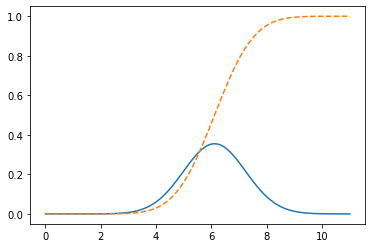

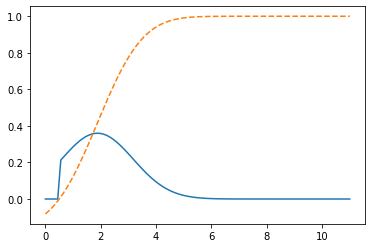

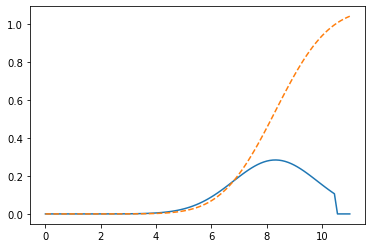

In [114]:
def trunc_pdf_ava(x, mu, sigma, a=0.5, b=10.5):
    def normalize(val):
        return (val-mu)/sigma
    phi_x = INV_SQRT_TWOPI * ((-0.5*(normalize(x)**2)).exp())
    big_phi_a = big_phi(normalize(torch.tensor(a)))
    big_phi_b = big_phi(normalize(torch.tensor(b)))
    pdf = phi_x / (big_phi_b-big_phi_a) / sigma
    return (pdf * (x>=a) * (x<=b)).clamp(0, 1)

def test_plot_torch(yy):
    y = torch.tensor(np.linspace(0, 11, 100))
    pdf_y = trunc_pdf_ava(y, yy[0], yy[1])
    cdf_y = trunc_cdf_ava(y, yy[0], yy[1])
    plt.plot(y, pdf_y)
    plt.plot(y, cdf_y, '--')
    plt.show()

test_plot_torch(y1[0].detach())
test_plot_torch(y2[0].detach())
test_plot_torch(y3[0].detach())